where entire graph is added as a node in parent graph

![Shared SubGraphs Diagram](./shared.png)

In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
class ParentState(TypedDict):

    question: str
    answer_eng: str
    answer_hin: str
    

In [4]:
parent_llm = ChatOllama(model="qwen3-vl:235b-instruct-cloud")
subgraph_llm = ChatOllama(model="qwen3-vl:235b-instruct-cloud")

In [5]:
def translate_text(state: ParentState):

    prompt = f"""
Translate the following text to Hindi.
Keep it natural and clear. Do not add extra content.

Text:
{state["answer_eng"]}
""".strip()
    
    translated_text = subgraph_llm.invoke(prompt).content

    return {'answer_hin': translated_text}

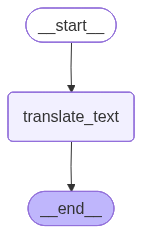

In [11]:
subgraph_builder = StateGraph(ParentState)

subgraph_builder.add_node('translate_text', translate_text)

subgraph_builder.add_edge(START, 'translate_text')
subgraph_builder.add_edge('translate_text', END)

subgraph = subgraph_builder.compile()
subgraph

In [7]:
def generate_answer(state: ParentState):

    answer = parent_llm.invoke(f"You are a helpful assistant. Answer clearly.\n\nQuestion: {state['question']}").content
    return {'answer_eng': answer}

In [ ]:
parent_builder = StateGraph(ParentState)

parent_builder.add_node("answer", generate_answer)
parent_builder.add_node("translate", subgraph)

parent_builder.add_edge(START, 'answer')
parent_builder.add_edge('answer', 'translate')
parent_builder.add_edge('translate', END)

graph = parent_builder.compile()
graph

In [10]:
graph.invoke({'question': 'What is quantum physics'})

{'question': 'What is quantum physics',
 'answer_eng': '**Quantum physics** (also called **quantum mechanics** or **quantum theory**) is the branch of physics that studies the behavior of matter and energy at the smallest scales — typically at the level of atoms, electrons, photons, and other subatomic particles.\n\n### Key Ideas in Quantum Physics:\n\n1. **Quantization**  \n   Energy, momentum, and other properties are not continuous but come in discrete “packets” called *quanta*. For example, electrons in an atom can only occupy specific energy levels.\n\n2. **Wave-Particle Duality**  \n   Particles like electrons and photons can behave both as particles (localized objects) and as waves (spread-out disturbances), depending on how you observe them.\n\n3. **Uncertainty Principle** (Heisenberg)  \n   You cannot simultaneously know both the exact position and momentum of a particle. The more precisely you know one, the less precisely you can know the other.\n\n4. **Superposition**  \n   